# Estimating Feature Effect on Adoption Time

### Call in packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
import re
import imgkit


import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.stats.api as sms

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
import sklearn.metrics 
import string

import lifelines
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines import KaplanMeierFitter

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_colwidth", -1)

In [2]:
dog_data_SF_19 = pd.read_csv('Model_Data/dog_data_w_tpcs_3_17_tps.csv')
dog_data_SF_19 =dog_data_SF_19.set_index('animal_id')


In [3]:
dog_data_SF_19['time_in_shelter'].describe()

count    19933.000000
mean     32.236793   
std      52.850609   
min      0.000000    
25%      5.000000    
50%      14.000000   
75%      36.000000   
max      664.000000  
Name: time_in_shelter, dtype: float64

In [4]:
dog_data_SF_19['time_adpt_med'] =1*(dog_data_SF_19['time_in_shelter'] < 14)

### Additional data cleaning / feature extraction

In [5]:
dog_data_SF_19['len_descr'][dog_data_SF_19['missing_description']==1] = 0

dog_data_SF_19['len_descr'].describe()

count    19933.000000
mean     813.273817  
std      739.298007  
min      0.000000    
25%      313.000000  
50%      574.000000  
75%      1027.000000 
max      8787.000000 
Name: len_descr, dtype: float64

In [6]:
dog_data_SF_19['min_desc'] = 0
dog_data_SF_19['min_desc'][dog_data_SF_19['len_descr'] <307] =1

dog_data_SF_19['min_desc'].describe()

count    19933.000000
mean     0.229820    
std      0.420727    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      1.000000    
Name: min_desc, dtype: float64

In [7]:
dog_data_SF_19 = dog_data_SF_19.dropna(subset=['len_descr'])

In [8]:
pd.Categorical.describe(dog_data_SF_19['colors_cat'])

,counts,freqs
categories,,
ct_light,6776,0.339939
ct_dark,6774,0.339838
ct_med,3433,0.172227
NaN,2950,0.147996


In [9]:
def gen_dummies(dataset, variable_list):
    for var in variable_list:
        dataset = pd.concat([dataset, pd.get_dummies(dataset[var], prefix=var)], axis=1)
    return dataset

In [10]:
dog_data_SF_19 = gen_dummies(dog_data_SF_19, ["pub_year"])

In [11]:
dog_data_SF_19 = gen_dummies(dog_data_SF_19, ["breeds.primary"])

### Data Exploration of Full Data Set

In [12]:
pd.Categorical.describe(dog_data_SF_19['age'])

,counts,freqs
categories,,
Baby,6862,0.344253
Adult,6835,0.342899
Young,5132,0.257462
Senior,1104,0.055386


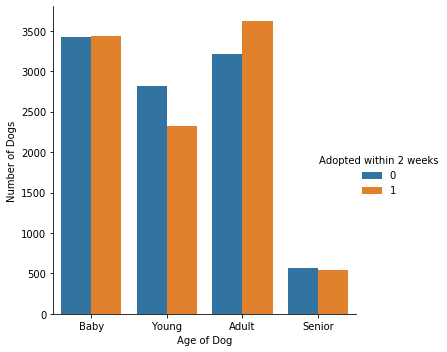

In [13]:
age_stats = sns.catplot(x="age", kind="count", hue="time_adpt_med", data=dog_data_SF_19)

age_stats.set(xlabel="Age of Dog", ylabel="Number of Dogs")
age_stats._legend.set_title("Adopted within 2 weeks")

plt.savefig("Demo_Figures/status_age.png")

In [14]:
pd.Categorical.describe(dog_data_SF_19['size'])

,counts,freqs
categories,,
Small,8659,0.434405
Medium,6788,0.340541
Large,4288,0.215121
Extra Large,198,0.009933


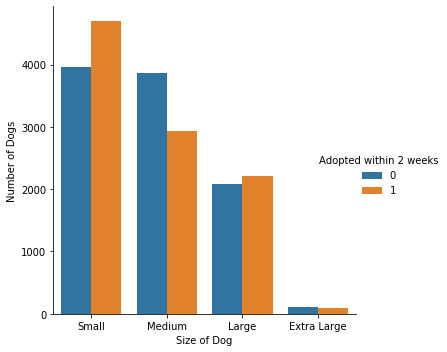

In [256]:
status_fig = sns.catplot(
    x="size",
    kind="count",
    hue="time_adpt_med",
    data=dog_data_SF_19 )

status_fig.set(xlabel='Size of Dog', ylabel="Number of Dogs")
status_fig._legend.set_title("Adopted within 2 weeks")

plt.savefig('Demo_Figures/status_size.png')
plt.show()

In [87]:
pd.Categorical.describe(dog_data_SF_19['gender'])

,counts,freqs
categories,,
Male,10010,0.502182
Female,9923,0.497818


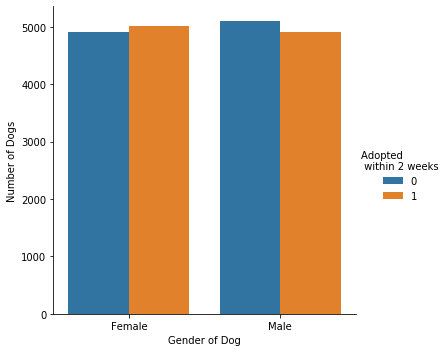

In [260]:
status_fig = sns.catplot(
    x="gender",
    kind="count",
    hue="time_adpt_med",
    data=dog_data_SF_19)

status_fig.set(xlabel='Gender of Dog', ylabel="Number of Dogs")
status_fig._legend.set_title("Adopted \n within 2 weeks")

plt.savefig('Demo_Figures/status_gender.png')
plt.show()

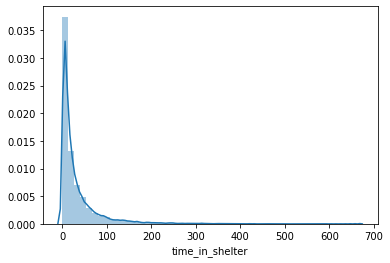

In [89]:
sns.distplot(dog_data_SF_19['time_in_shelter']);

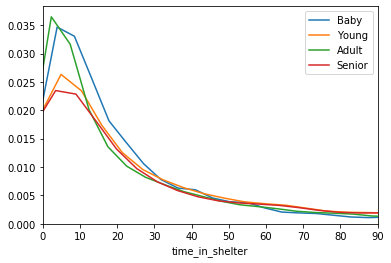

In [50]:
def comp_dist(df_to_use, cat_to_subset, var_dist):
    for grp in df_to_use[cat_to_subset].unique():
        grp_df = df_to_use.loc[df_to_use[cat_to_subset] == grp]
        sns.distplot(grp_df[var_dist], hist=False, label=grp)
        plt.xlim(0, 90)
    plt.show()


comp_dist(dog_data_SF_19, "age", "time_in_shelter")

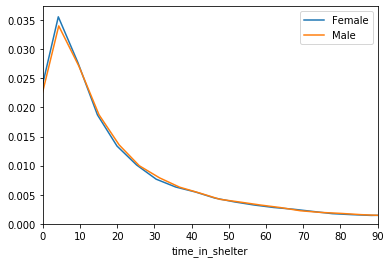

In [51]:
comp_dist(dog_data_SF_19,'gender','time_in_shelter')        

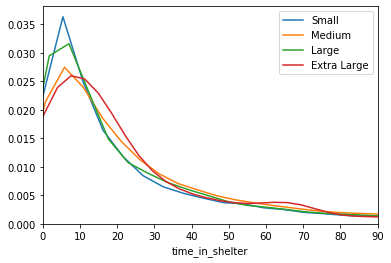

In [52]:
comp_dist(dog_data_SF_19,'size','time_in_shelter')        

In [53]:
pd.Categorical.describe(dog_data_SF_19['coat'])

,counts,freqs
categories,,
Short,10726,0.538103
Medium,4351,0.218281
NaN,2870,0.143982
Long,1224,0.061406
Wire,450,0.022576
Curly,301,0.015101
Hairless,11,0.000552


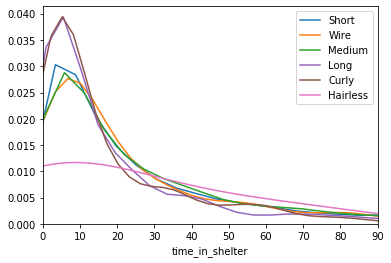

In [54]:
comp_dist(dog_data_SF_19,'coat','time_in_shelter')        

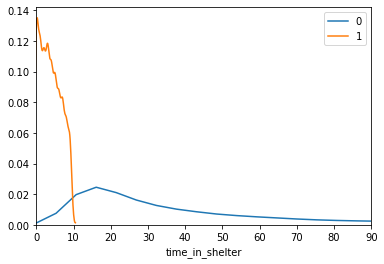

In [55]:
comp_dist(dog_data_SF_19,'time_adpt_med','time_in_shelter')        

In [56]:
pd.Categorical.describe(dog_data_SF_19['time_adpt_med'])

,counts,freqs
categories,,
0,11859,0.594943
1,8074,0.405057


In [15]:
pd.pivot_table(
    dog_data_SF_19[["time_adpt_med", "time_in_shelter"]],
    columns="time_adpt_med",
    aggfunc=np.min
)

time_adpt_med,0,1
time_in_shelter,14.0,0.0


In [19]:
dog_data_SF_19[features].describe()

,num_photo,attributes.spayed_neutered,attributes.house_trained,attributes.special_needs,attributes.shots_current,num_tags,age_Senior,age_Young,age_Adult,gender_Male,...,breeds.primary_Chihuahua,breeds.primary_Terrier,breeds.primary_Labrador Retriever,breeds.primary_German Shepherd Dog,breeds.primary_Pit Bull Terrier,breeds.primary_Shepherd,breeds.primary_American Staffordshire Terrier,breeds.primary_Dachshund,breeds.primary_Poodle,breeds.primary_Border Collie
count,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,...,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000
mean,2.924597,0.786184,0.316912,0.015753,0.731852,9.131240,0.055386,0.257462,0.342899,0.502182,...,0.124868,0.101289,0.088095,0.070436,0.051171,0.039081,0.035268,0.032960,0.025786,0.023127
std,1.695570,0.410009,0.465284,0.124521,0.443006,20.065489,0.228737,0.437247,0.474690,0.500008,...,0.330578,0.301719,0.283440,0.255887,0.220353,0.193792,0.184461,0.178537,0.158501,0.150312
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,1.000000,1.000000,1.000000,1.000000,329.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [488]:
#Checking out relationships 
full_data_corr = dog_data_SF_19[features].corr()

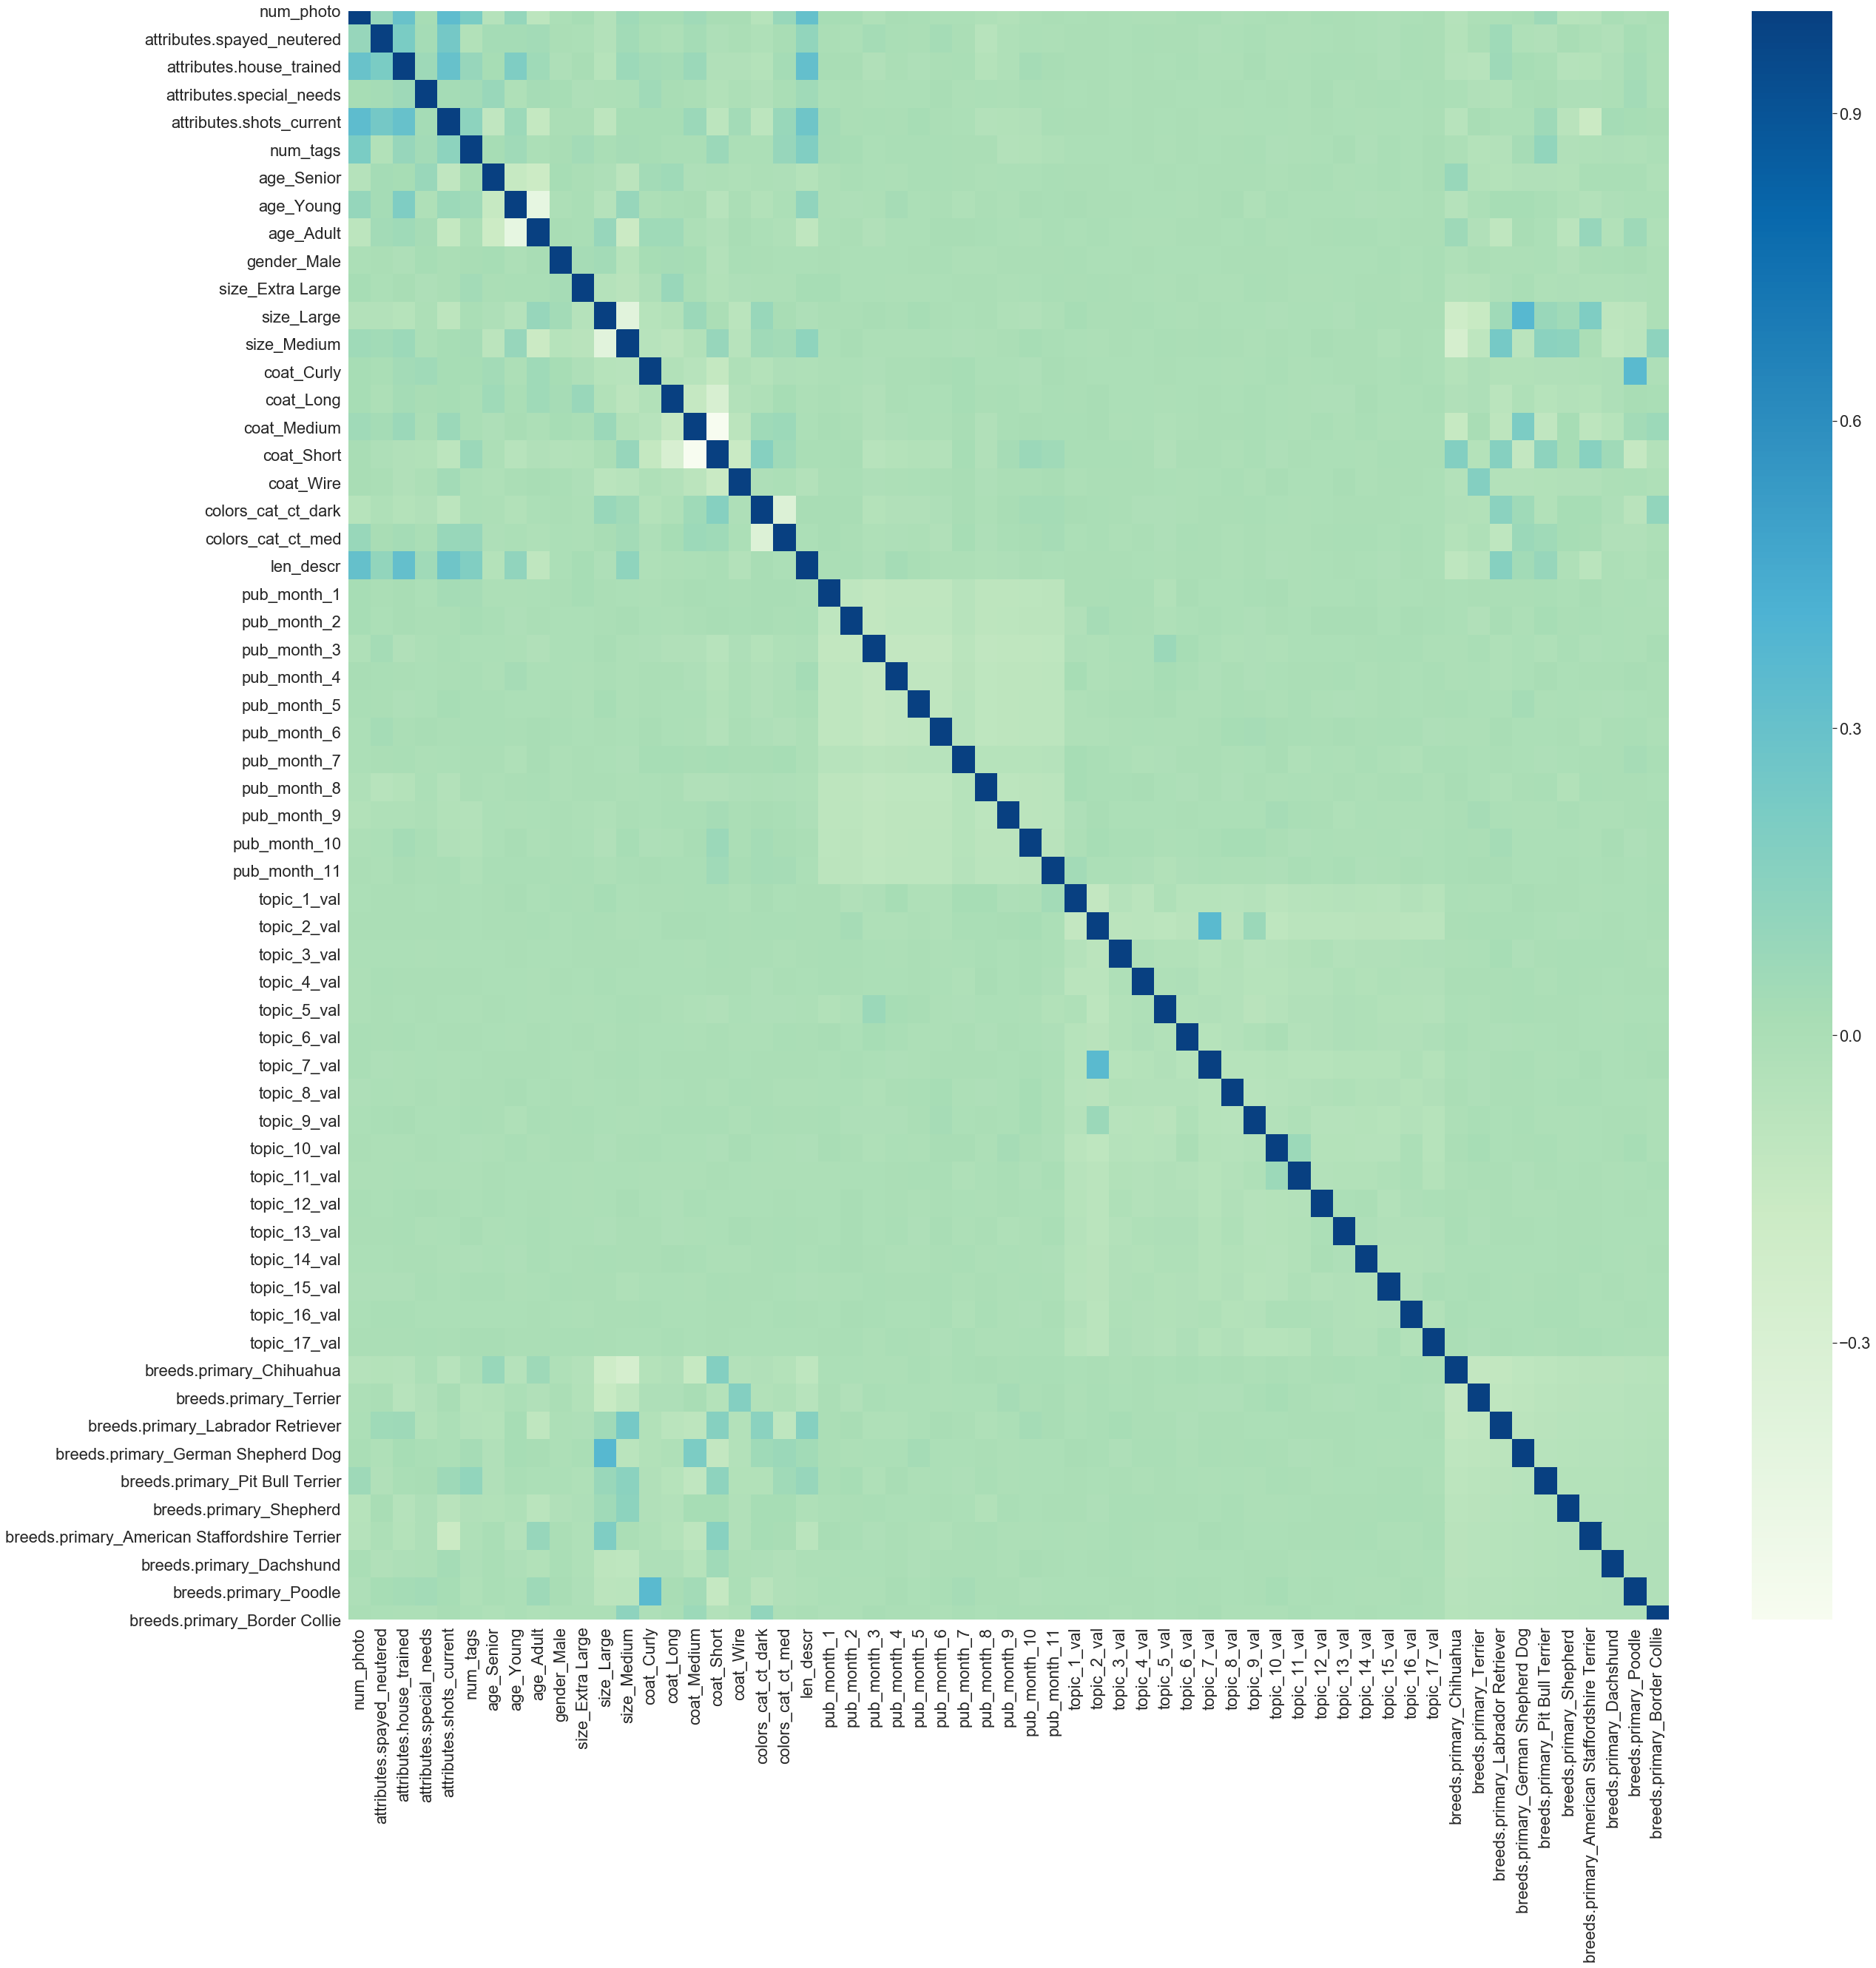

In [487]:
f, ax = plt.subplots(figsize=(40, 40))
# sns.set(font_scale=1)  
sns.heatmap(
    full_data_corr,
#     annot=True,
#     annot_kws={"size": 40},
    cmap="GnBu",
#     cbar=False,
    fmt=" ",
    ax=ax,
);
# ax.set_ylim(2, 0);

plt.savefig("Demo_Figures/full_corr_matrix.png")

### Models

In [23]:
dog_data_SF_19_mdl = dog_data_SF_19

In [219]:
dog_data_SF_19.columns

Index(['Unnamed: 0', 'num_photo', 'url', 'age', 'gender', 'size', 'coat',
       'name', 'status', 'breeds.primary',
       ...
       'age_Seniortopic_8_val', 'age_Seniortopic_9_val',
       'age_Seniortopic_10_val', 'age_Seniortopic_11_val',
       'age_Seniortopic_12_val', 'age_Seniortopic_13_val',
       'age_Seniortopic_14_val', 'age_Seniortopic_15_val',
       'age_Seniortopic_16_val', 'age_Seniortopic_17_val'],
      dtype='object', length=449)

### Logistic Models 

In [17]:
top_breeds = [
    "breeds.primary_Chihuahua",
    "breeds.primary_Terrier",
    "breeds.primary_Labrador Retriever",
    "breeds.primary_German Shepherd Dog",
    "breeds.primary_Pit Bull Terrier",
    "breeds.primary_Shepherd",
    "breeds.primary_American Staffordshire Terrier",
    "breeds.primary_Dachshund",
    "breeds.primary_Poodle",
    "breeds.primary_Border Collie"
]

In [18]:
features = [
    "num_photo",
        "attributes.spayed_neutered",
        "attributes.house_trained",
        "attributes.special_needs",
        "attributes.shots_current",
    "num_tags",
        "age_Senior",
    "age_Young",
    "age_Adult",
    "gender_Male",
    "size_Extra Large",
    "size_Large",
    "size_Medium",
    "coat_Curly",
            "coat_Long",
            "coat_Medium",
            "coat_Short",
            "coat_Wire",
    "colors_cat_ct_dark",
            "colors_cat_ct_med",
    #     "min_desc",
        "len_descr",
    "pub_month_1",
    "pub_month_2",
    "pub_month_3",
    "pub_month_4",
    "pub_month_5",
    "pub_month_6",
    "pub_month_7",
    "pub_month_8",
    "pub_month_9",
    "pub_month_10",
    "pub_month_11",
    #     "pub_month_12",
    "topic_1_val",
    "topic_2_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_6_val",
    "topic_7_val",
    "topic_8_val",
    "topic_9_val",
    "topic_10_val",
    "topic_11_val",
    "topic_12_val",
    "topic_13_val",
    "topic_14_val",
    "topic_15_val",
    "topic_16_val",
    "topic_17_val",
] + top_breeds

In [96]:
dd_sf_train, dd_sf_test = sklearn.model_selection.train_test_split(dog_data_SF_19_mdl, test_size=0.2, random_state=666)
print(dd_sf_train.shape,dd_sf_test.shape)


(15946, 311) (3987, 311)


### Full Model

In [269]:
 # first optimizing a logistic model with all features
flog = LogisticRegression(random_state=1)
scoring = {'Log_loss': 'neg_log_loss', 'F1_Score': 'f1'}
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv_gr=GridSearchCV(flog,grid,cv=20, verbose=1, scoring = scoring, refit='F1_Score')
logreg_cv =logreg_cv_gr.fit(dd_sf_train[features], dd_sf_train['time_adpt_med'])



Fitting 20 folds for each of 14 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   39.6s finished


In [1]:
logreg_cv

In [2]:
logreg_cv

In [271]:
logreg_cv_gr.best_score_

0.6841217391353329

In [278]:
dd_sf_train["log_predicted"] = logreg_cv.predict(dd_sf_train[features]) 

In [279]:
sklearn.metrics.accuracy_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)

0.6793553242192399

In [280]:
sklearn.metrics.recall_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  # But increases recall

0.7017081135393117

In [281]:
sklearn.metrics.f1_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  

0.6860686437035672

In [282]:
sklearn.metrics.confusion_matrix(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  

array([[5246, 2738],
       [2375, 5587]])

#### On testing data

In [283]:
dd_sf_test["log_predicted_test"] = logreg_cv.predict(dd_sf_test[features]) 

In [284]:
sklearn.metrics.accuracy_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test"]
)

0.6794582392776524

In [285]:
sklearn.metrics.recall_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test"]
)  # But increases recall

0.6995401124169648

In [286]:
sklearn.metrics.f1_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test"]
)  

0.6817729083665338

In [287]:
sklearn.metrics.confusion_matrix(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test"]
)  

array([[1340,  690],
       [ 588, 1369]])

In [112]:
# comp_dist(dd_sf_train, "log_predicted", "time_in_shelter")

### Without topics 

In [290]:
features_notops = [
#     "num_photo",
        "attributes.spayed_neutered",
        "attributes.house_trained",
        "attributes.special_needs",
        "attributes.shots_current",
#     "num_tags",
        "age_Baby",
    "age_Young",
    "age_Adult",
    "gender_Male",
    "size_Extra Large",
    "size_Large",
    "size_Medium",
    "coat_Curly",
            "coat_Long",
            "coat_Medium",
            "coat_Short",
            "coat_Wire",
    "colors_cat_ct_dark",
            "colors_cat_ct_med",
    #     "min_desc",
#         "len_descr",
    "pub_month_1",
    "pub_month_2",
    "pub_month_3",
    "pub_month_4",
    "pub_month_5",
    "pub_month_6",
    "pub_month_7",
    "pub_month_8",
    "pub_month_9",
    "pub_month_10",
    "pub_month_11",
    #     "pub_month_12",
#     "topic_1_val",
#     "topic_2_val",
#     "topic_3_val",
#     "topic_4_val",
#     "topic_5_val",
#     "topic_6_val",
#     "topic_7_val",
#     "topic_8_val",
#     "topic_9_val",
#     "topic_10_val",
#     "topic_11_val",
#     "topic_12_val",
#     "topic_13_val",
#     "topic_14_val",
#     "topic_15_val",
#     "topic_16_val",
#     "topic_17_val",
] + top_breeds

In [291]:
logreg_cv_gr_notps=GridSearchCV(flog,grid,cv=20, verbose=1, scoring = scoring, refit='F1_Score')
logreg_cv_notps =logreg_cv_gr_notps.fit(dd_sf_train[features_notops], dd_sf_train['time_adpt_med'])



Fitting 20 folds for each of 14 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   31.8s finished


In [292]:
logreg_cv_notps

GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit='F1_Score',
             return_train_score=False,
             scoring={'F1_Score': 'f1', 'Log_loss': 'neg_log_loss'}, verbose=1)

In [293]:
logreg_cv_gr_notps.best_score_

0.6521875268142776

In [294]:
dd_sf_train["log_pred_no_topics"] = logreg_cv_notps.predict(dd_sf_train[features_notops]) 


In [289]:
# comp_dist(dd_sf_train, "log_pred_no_topics", "time_in_shelter")

In [295]:
sklearn.metrics.accuracy_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
) - sklearn.metrics.accuracy_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
)

0.02389313934529036

In [323]:
sklearn.metrics.accuracy_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
)

0.6554621848739496

In [308]:
sklearn.metrics.precision_score(dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
) 

0.6562420866042036

In [297]:
sklearn.metrics.recall_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
)  # But increases recall

0.6509670936950515

In [298]:
sklearn.metrics.f1_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
)  

0.65359394703657

In [394]:
sklearn.metrics.confusion_matrix(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_pred_no_topics"]
)                        

#### On testing data

In [429]:
dd_sf_test["log_predicted_test_nptpc"] = logreg_cv_notps.predict(dd_sf_test[features_notops]) 

In [431]:
sklearn.metrics.precision_score(dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test_nptpc"]
) 

0.6612576064908722

In [432]:
sklearn.metrics.accuracy_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test_nptpc"]
)

0.6686731878605467

In [433]:
sklearn.metrics.recall_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test_nptpc"]
)  # But increases recall

0.6663260091977516

In [434]:
sklearn.metrics.f1_score(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test_nptpc"]
)  

0.6637821328582336

In [434]:
sklearn.metrics.confusion_matrix(
    dd_sf_test["time_adpt_med"], dd_sf_test["log_predicted_test_nptpc"]
)  

array([[1362,  668],
       [ 653, 1304]])

In [299]:
sklearn.metrics.accuracy_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)

0.6793553242192399

In [305]:
sklearn.metrics.precision_score(dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
) 

0.6711111111111111

In [300]:
sklearn.metrics.recall_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  # But increases recall

0.7017081135393117

In [301]:
sklearn.metrics.f1_score(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  

0.6860686437035672

In [439]:
print(dd_sf_train[["time_adpt_med","log_predicted"]].sum())
dd_sf_train[["time_adpt_med","log_predicted"]].describe()

time_adpt_med    7962
log_predicted    8325
dtype: int64


,time_adpt_med,log_predicted
count,15946.000000,15946.000000
mean,0.499310,0.522075
std,0.500015,0.499528
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [303]:
confusion = sklearn.metrics.confusion_matrix(
    dd_sf_train["time_adpt_med"], dd_sf_train["log_predicted"]
)  

confusion

array([[5246, 2738],
       [2375, 5587]])

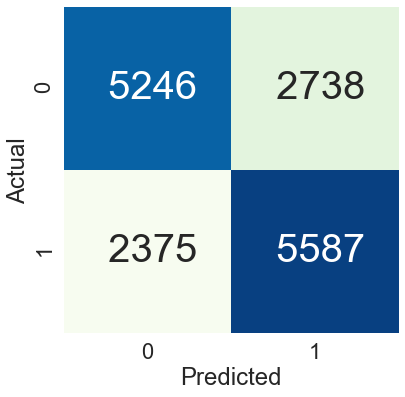

In [436]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=2)  
sns.heatmap(
    confusion,
    annot=True,
    annot_kws={"size": 40},
    cmap="GnBu",
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set(xlabel='Predicted', ylabel="Actual")
ax.set_ylim(2, 0);

plt.savefig("Demo_Figures/Full_model_confusion_matrix.png")

### Traditional model for comparisons

In [3]:
logreg_cv_gr_notps.best_estimator_.coef_

In [272]:
logit_model=sm.Logit( dd_sf_train['time_adpt_med'],dd_sf_train[features])
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.615592
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          time_adpt_med   No. Observations:                15946
Model:                          Logit   Df Residuals:                    15887
Method:                           MLE   Df Model:                           58
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1119
Time:                        11:52:09   Log-Likelihood:                -9816.2
converged:                       True   LL-Null:                       -11053.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
num_photo                             

In [258]:
## pickle up the model 

# filename_efect_mdl = 'effects_log_model.sav'
# pickle.dump(result, open(filename_efect_mdl, 'wb'))

In [273]:
effects = pd.DataFrame(round(((np.exp(result.params) - 1)*100),))

In [274]:
effects[32:49]

,0
topic_1_val,10.0
topic_2_val,5.0
topic_3_val,16.0
topic_4_val,10.0
topic_5_val,22.0
topic_6_val,9.0
topic_7_val,17.0
topic_8_val,9.0
topic_9_val,6.0
topic_10_val,11.0


In [152]:
effects["p-values"] = result.pvalues

In [154]:
effects.to_csv("full_logistic_results.csv")

In [275]:
effects

,0
num_photo,-19.0
attributes.spayed_neutered,-10.0
attributes.house_trained,-39.0
attributes.special_needs,-34.0
attributes.shots_current,-36.0
num_tags,-0.0
age_Baby,214.0
age_Young,195.0
age_Adult,195.0
gender_Male,-0.0


In [363]:
Dog_Characteristics = [
    "Active and Smart",
    "Slow or fit",
    "Quiet",
    "Calm",
    "Outgoing",
    "Furry",
    "Playful",
    "Ideal",
    "Easy-going",
    "Adoption Process",
    "Strong, secure",
    "Affectionate, nice",
    "Energetic, trainable",
    "Confident, loyal",
    "Kind, sensitive",
    "Friendly, snuggler",
    "Typical puppy"
]

In [366]:
topic_effects.shape

(17, 1)

In [367]:
Dog_Characteristics

['Active and Smart',
 'Slow or fit',
 'Quiet, delightful',
 'Calm',
 'Outgoing',
 'Furry',
 'Playful',
 'Ideal',
 'Easy-going',
 'Adoption Process',
 'Strong, secure',
 'Wonderful, affectionate, nice',
 'Amazing, energetic, trainable',
 'Confident, loyal',
 'Kind, sensitive',
 'Friendly, snuggler',
 'Typical puppy']

In [368]:
topic_effects['topic_label'] = Dog_Characteristics

In [369]:
topic_effects

,0,topic_label
topic_1_val,16.0,Active and Smart
topic_2_val,12.0,Slow or fit
topic_3_val,23.0,"Quiet, delightful"
topic_4_val,17.0,Calm
topic_5_val,30.0,Outgoing
topic_6_val,15.0,Furry
topic_7_val,21.0,Playful
topic_8_val,15.0,Ideal
topic_9_val,12.0,Easy-going
topic_10_val,19.0,Adoption Process


In [370]:
topic_effects = topic_effects.drop(
    ["topic_2_val", "topic_6_val", "topic_15_val", "topic_16_val", "topic_10_val"]
)

In [371]:
topic_effects.columns = ["Percentage_increase", "Dog_characteristic"]

In [372]:
topic_effects = topic_effects[["Dog_characteristic","Percentage_increase"]]

In [373]:
topic_effects = topic_effects.sort_values("Percentage_increase", ascending=False)

In [374]:
topic_effects.to_csv("topics_effects.csv", index=False)

In [390]:
testing_table = pd.read_csv("/Users/allisonkelly/Documents/Insight/flaskapp-master/flaskexample/topics_effects.csv",index_col=False)

In [391]:
testing_table

,Dog_characteristic,Percentage_increase
0,Outgoing,30.0
1,"Amazing, energetic, trainable",30.0
2,Typical puppy,27.0
3,"Confident, loyal",26.0
4,"Quiet, delightful",23.0
5,"Wonderful, affectionate, nice",22.0
6,Playful,21.0
7,Calm,17.0
8,Active and Smart,16.0
9,"Strong, secure",16.0


## Final Model

In [106]:
effect_model = pickle.load(
    open("effects_log_model.sav", "rb")
)

In [ ]:
effect_model.summary()

In [111]:
effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          time_adpt_med   No. Observations:                15946
Model:                          Logit   Df Residuals:                    15887
Method:                           MLE   Df Model:                           58
Date:                Tue, 01 Oct 2019   Pseudo R-squ.:                  0.1009
Time:                        10:26:18   Log-Likelihood:                -9938.0
converged:                       True   LL-Null:                       -11053.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
num_photo                                        -0.1967      0.011    -17.286      0.000      -0.219      -0.174
attributes.spayed_neutered                       -0.0872      0.043     -2.025      0.043      -0.172      -0.003
attributes.house_trained                         -0.6191      0.043    -14.448      0.000      -0.703      -0.535
attributes.special_needs                         -0.5200      0.146     -3.551      0.000      -0.807      -0.233
attributes.shots_current                         -0.2613      0.044     -5.897      0.000      -0.348      -0.174
num_tags                                         -0.0014      0.001     -1.516      0.130      -0.003       0.000
age_Young                                         0.1741      0.046      3.766      0.000       0.083       0.265
age_Adult                                         0.2188      0.043      5.044      0.000       0.134       0.304
age_Senior                                       -0.0349      0.081     -0.430      0.667      -0.194       0.124
gender_Male                                       0.0317      0.034      0.938      0.348      -0.035       0.098
size_Extra Large                                 -0.1289      0.172     -0.748      0.455      -0.467       0.209
size_Large                                        0.2474      0.059      4.205      0.000       0.132       0.363
size_Medium                                      -0.0163      0.049     -0.331      0.741      -0.113       0.080
coat_Curly                                        0.5814      0.159      3.665      0.000       0.270       0.892
coat_Long                                         0.2970      0.085      3.493      0.000       0.130       0.464
coat_Medium                                      -0.2002      0.061     -3.296      0.001      -0.319      -0.081
coat_Short                                       -0.2904      0.055     -5.310      0.000      -0.398      -0.183
coat_Wire                                        -0.1465      0.124     -1.183      0.237      -0.389       0.096
colors_cat_ct_dark                                0.0789      0.042      1.870      0.062      -0.004       0.162
colors_cat_ct_med                                 0.0102      0.051      0.199      0.842      -0.090       0.110
len_descr                                        -0.0001   2.84e-05     -4.761      0.000      -0.000   -7.95e-05
pub_month_1                                       0.8063      0.078     10.280      0.000       0.653       0.960
pub_month_2                                       0.8456      0.080     10.631      0.000       0.690       1.001
pub_month_3                                       1.0739      0.071     15.107      0.000       0.935       1.213
pub_month_4                                       0.9386      0.076     12.387      0.000       0.790       1.087
pub_month_5                                      

In [322]:
effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          time_adpt_med   No. Observations:                15946
Model:                          Logit   Df Residuals:                    15887
Method:                           MLE   Df Model:                           58
Date:                Thu, 03 Oct 2019   Pseudo R-squ.:                  0.1009
Time:                        09:44:36   Log-Likelihood:                -9938.0
converged:                       True   LL-Null:                       -11053.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
num_photo                                        -0.1967      0.011    -17.286      0.000      -0.219      -0.174
attributes.spayed_neutered                       -0.0872      0.043     -2.025      0.043      -0.172      -0.003
attributes.house_trained                         -0.6191      0.043    -14.448      0.000      -0.703      -0.535
attributes.special_needs                         -0.5200      0.146     -3.551      0.000      -0.807      -0.233
attributes.shots_current                         -0.2613      0.044     -5.897      0.000      -0.348      -0.174
num_tags                                         -0.0014      0.001     -1.516      0.130      -0.003       0.000
age_Young                                         0.1741      0.046      3.766      0.000       0.083       0.265
age_Adult                                         0.2188      0.043      5.044      0.000       0.134       0.304
age_Senior                                       -0.0349      0.081     -0.430      0.667      -0.194       0.124
gender_Male                                       0.0317      0.034      0.938      0.348      -0.035       0.098
size_Extra Large                                 -0.1289      0.172     -0.748      0.455      -0.467       0.209
size_Large                                        0.2474      0.059      4.205      0.000       0.132       0.363
size_Medium                                      -0.0163      0.049     -0.331      0.741      -0.113       0.080
coat_Curly                                        0.5814      0.159      3.665      0.000       0.270       0.892
coat_Long                                         0.2970      0.085      3.493      0.000       0.130       0.464
coat_Medium                                      -0.2002      0.061     -3.296      0.001      -0.319      -0.081
coat_Short                                       -0.2904      0.055     -5.310      0.000      -0.398      -0.183
coat_Wire                                        -0.1465      0.124     -1.183      0.237      -0.389       0.096
colors_cat_ct_dark                                0.0789      0.042      1.870      0.062      -0.004       0.162
colors_cat_ct_med                                 0.0102      0.051      0.199      0.842      -0.090       0.110
len_descr                                        -0.0001   2.84e-05     -4.761      0.000      -0.000   -7.95e-05
pub_month_1                                       0.8063      0.078     10.280      0.000       0.653       0.960
pub_month_2                                       0.8456      0.080     10.631      0.000       0.690       1.001
pub_month_3                                       1.0739      0.071     15.107      0.000       0.935       1.213
pub_month_4                                       0.9386      0.076     12.387      0.000       0.790       1.087
pub_month_5                                      

In [ ]:
effect_model.predict(dog_data_SF_19_mdl[1])

In [30]:
dog_data_SF_19_mdl[features].iloc[1,:]

num_photo                                        5.0  
attributes.spayed_neutered                       1.0  
attributes.house_trained                         0.0  
attributes.special_needs                         0.0  
attributes.shots_current                         1.0  
num_tags                                         2.0  
age_Senior                                       0.0  
age_Young                                        0.0  
age_Adult                                        0.0  
gender_Male                                      1.0  
size_Extra Large                                 0.0  
size_Large                                       0.0  
size_Medium                                      0.0  
coat_Curly                                       0.0  
coat_Long                                        0.0  
coat_Medium                                      0.0  
coat_Short                                       1.0  
coat_Wire                                        0.0  
colors_cat

In [422]:
buck_impact = pd.DataFrame([dog_data_SF_19_mdl[features].iloc[1,:]]*2)

In [423]:
topic_val_1 = ["topic_1_val",
    "topic_3_val",
    "topic_4_val"]

for top in topic_val_1:
    buck_impact[top].iloc[0:] = 1.0


In [424]:
topic_val_2 = ["topic_1_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_13_val",
    "topic_14_val"]

for top in topic_val_2:
    buck_impact[top].iloc[1:] = 1.0

In [425]:
buck_impact[topic_val]

,topic_1_val,topic_3_val,topic_4_val,topic_5_val,topic_7_val,topic_8_val,topic_9_val,topic_11_val,topic_12_val,topic_13_val,topic_14_val,topic_17_val
45132825,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45132825,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [426]:
effect_model.predict(buck_impact[features])

45132825    0.507738
45132825    0.687875
dtype: float64

### Survival Model 
fits the problem well, fits the data poorly, insights aren't as actionable


In [262]:
imp_topics =  [
            "topic_1_val",
            "topic_3_val",
            "topic_4_val",
            "topic_5_val",
            "topic_7_val",
            "topic_8_val",
            "topic_9_val",
            "topic_11_val",
            "topic_12_val",
            "topic_13_val",
            "topic_14_val",
            "topic_17_val",
        ]

In [263]:
dog_data_SF_19_mdl[imp_topics].columns

Index(['topic_1_val', 'topic_3_val', 'topic_4_val', 'topic_5_val',
       'topic_7_val', 'topic_8_val', 'topic_9_val', 'topic_11_val',
       'topic_12_val', 'topic_13_val', 'topic_14_val', 'topic_17_val'],
      dtype='object')

In [142]:
dog_data_SF_19_mdl['many_topics'] = dog_data_SF_19_mdl[imp_topics].apply(sum, axis = 1)

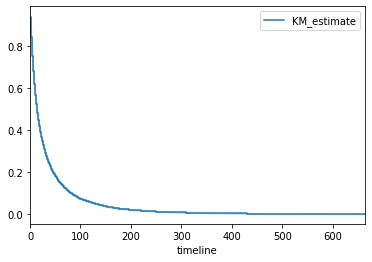

In [135]:
dog_data_SF_19_mdl['status_1'] = 1

kmf = KaplanMeierFitter()
kmf.fit(dog_data_SF_19_mdl['time_in_shelter'], dog_data_SF_19_mdl['status_1'])  


kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.plot_survival_function();

In [58]:
# kmf.survival_function_

In [59]:
# kmf.cumulative_density_

In [142]:
kmf.median_

14.0

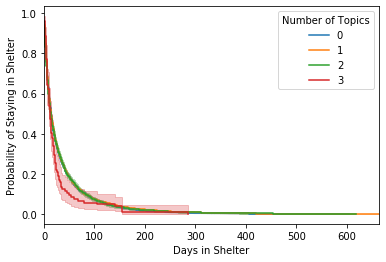

In [146]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in dog_data_SF_19_mdl.groupby('many_topics'):
    kmf.fit(grouped_df['time_in_shelter'], grouped_df['status_1'], label=name)
    kmf.plot(ax=ax)

ax.set(xlabel="Days in Shelter", ylabel="Probability of Staying in Shelter")
ax.legend(title= "Number of Topics")
;
    
plt.savefig("survival_topic.png")    

In [160]:
cph = CoxPHFitter()
cph.fit(
    dog_data_SF_19_mdl[["time_in_shelter","status_1"] +features],
    duration_col="time_in_shelter",
    event_col="status_1",
    show_progress=True)

cph.print_summary()  

Iteration 1: norm_delta = 0.35187, step_size = 0.9500, ll = -177412.19874, newton_decrement = 1149.18800, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.03215, step_size = 0.9500, ll = -176260.49398, newton_decrement = 10.56777, seconds_since_start = 0.4
Iteration 3: norm_delta = 0.00212, step_size = 0.9500, ll = -176249.86067, newton_decrement = 0.04595, seconds_since_start = 0.7
Iteration 4: norm_delta = 0.00011, step_size = 1.0000, ll = -176249.81480, newton_decrement = 0.00012, seconds_since_start = 0.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -176249.81468, newton_decrement = 0.00000, seconds_since_start = 1.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 19933 observations, 0 censored>
      duration col = 'time_in_shelter'
         event col = 'status_1'
number of subjects = 19933
  number of events = 19933
    log-likelihood = -176249.81
  time fit was run = 2019-09-25 05:21:05 UTC

---
                                  

In [163]:
# cph.check_assumptions(dog_data_SF_19_mdl[["time_in_shelter","status_1"] +features].reset_index(drop=True)) 

### Interaction terms

In [211]:
feat_int = [
    "topic_1_val",
    "topic_2_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_6_val",
    "topic_7_val",
    "topic_8_val",
    "topic_9_val",
    "topic_10_val",
    "topic_11_val",
    "topic_12_val",
    "topic_13_val",
    "topic_14_val",
    "topic_15_val",
    "topic_16_val",
    "topic_17_val",
]

feat_age = ["age_Baby", "age_Young", "age_Adult", "age_Senior"]

In [212]:
def create_interactions(list_1, list_2, dataframe):
    for feat in list_1:
        for tops in list_2:
            dataframe[feat + tops] = (dataframe[feat]*dataframe[tops])           

In [213]:
create_interactions(feat_age, feat_int,dog_data_SF_19_mdl)

In [215]:
dog_data_SF_19_mdl.shape

(19933, 449)

In [222]:
dog_data_SF_19_mdl.columns[360:]

Index(['topic_12_valage_Senior', 'topic_13_valage_Baby',
       'topic_13_valage_Young', 'topic_13_valage_Adult',
       'topic_13_valage_Senior', 'topic_14_valage_Baby',
       'topic_14_valage_Young', 'topic_14_valage_Adult',
       'topic_14_valage_Senior', 'topic_15_valage_Baby',
       'topic_15_valage_Young', 'topic_15_valage_Adult',
       'topic_15_valage_Senior', 'topic_16_valage_Baby',
       'topic_16_valage_Young', 'topic_16_valage_Adult',
       'topic_16_valage_Senior', 'topic_17_valage_Baby',
       'topic_17_valage_Young', 'topic_17_valage_Adult',
       'topic_17_valage_Senior', 'age_Babytopic_1_val', 'age_Babytopic_2_val',
       'age_Babytopic_3_val', 'age_Babytopic_4_val', 'age_Babytopic_5_val',
       'age_Babytopic_6_val', 'age_Babytopic_7_val', 'age_Babytopic_8_val',
       'age_Babytopic_9_val', 'age_Babytopic_10_val', 'age_Babytopic_11_val',
       'age_Babytopic_12_val', 'age_Babytopic_13_val', 'age_Babytopic_14_val',
       'age_Babytopic_15_val', 'age_Babyto

In [264]:
feat_bby = [
    "num_photo",
    "attributes.spayed_neutered",
    "attributes.house_trained",
    "attributes.special_needs",
    "attributes.shots_current",
    "num_tags",
        "age_Baby",
    "age_Young",
    "age_Adult",
#     "age_Senior",
    "gender_Male",
    "size_Extra Large",
    "size_Large",
    "size_Medium",
    "coat_Curly",
    "coat_Long",
    "coat_Medium",
    "coat_Short",
    "coat_Wire",
    "colors_cat_ct_dark",
    "colors_cat_ct_med",
    "len_descr",
    "pub_month_1",
    "pub_month_2",
    "pub_month_3",
    "pub_month_4",
    "pub_month_5",
    "pub_month_6",
    "pub_month_7",
    "pub_month_8",
    "pub_month_9",
    "pub_month_10",
    "pub_month_11",
        "topic_1_val",
        "topic_2_val",
        "topic_3_val",
        "topic_4_val",
        "topic_5_val",
        "topic_6_val",
        "topic_7_val",
        "topic_8_val",
        "topic_9_val",
        "topic_10_val",
        "topic_11_val",
        "topic_12_val",
        "topic_13_val",
        "topic_14_val",
        "topic_15_val",
        "topic_16_val",
        "topic_17_val",
    "age_Babytopic_1_val",
    "age_Babytopic_2_val",
    "age_Babytopic_3_val",
    "age_Babytopic_4_val",
    "age_Babytopic_5_val",
    "age_Babytopic_6_val",
    "age_Babytopic_7_val",
    "age_Babytopic_8_val",
    "age_Babytopic_9_val",
    "age_Babytopic_10_val",
    "age_Babytopic_11_val",
    "age_Babytopic_12_val",
    "age_Babytopic_13_val",
    "age_Babytopic_14_val",
    "age_Babytopic_15_val",
    "age_Babytopic_16_val",
    "age_Babytopic_17_val",
#     "age_Youngtopic_1_val",
#     "age_Youngtopic_2_val",
#     "age_Youngtopic_3_val",
#     "age_Youngtopic_4_val",
#     "age_Youngtopic_5_val",
#     "age_Youngtopic_6_val",
#     "age_Youngtopic_7_val",
#     "age_Youngtopic_8_val",
#     "age_Youngtopic_9_val",
#     "age_Youngtopic_10_val",
#     "age_Youngtopic_11_val",
#     "age_Youngtopic_12_val",
#     "age_Youngtopic_13_val",
#     "age_Youngtopic_14_val",
#     "age_Youngtopic_15_val",
#     "age_Youngtopic_16_val",
#     "age_Youngtopic_17_val",
#     "age_Adulttopic_1_val",
#     "age_Adulttopic_2_val",
#     "age_Adulttopic_3_val",
#     "age_Adulttopic_4_val",
#     "age_Adulttopic_5_val",
#     "age_Adulttopic_6_val",
#     "age_Adulttopic_7_val",
#     "age_Adulttopic_8_val",
#     "age_Adulttopic_9_val",
#     "age_Adulttopic_10_val",
#     "age_Adulttopic_11_val",
#     "age_Adulttopic_12_val",
#     "age_Adulttopic_13_val",
#     "age_Adulttopic_14_val",
#     "age_Adulttopic_15_val",
#     "age_Adulttopic_16_val",
#     "age_Adulttopic_17_val",
#     "age_Seniortopic_1_val",
#     "age_Seniortopic_2_val",
#     "age_Seniortopic_3_val",
#     "age_Seniortopic_4_val",
#     "age_Seniortopic_5_val",
#     "age_Seniortopic_6_val",
#     "age_Seniortopic_7_val",
#     "age_Seniortopic_8_val",
#     "age_Seniortopic_9_val",
#     "age_Seniortopic_10_val",
#     "age_Seniortopic_11_val",
#     "age_Seniortopic_12_val",
#     "age_Seniortopic_13_val",
#     "age_Seniortopic_14_val",
#     "age_Seniortopic_15_val",
#     "age_Seniortopic_16_val",
#     "age_Seniortopic_17_val",
    "breeds.primary_Chihuahua",
    "breeds.primary_Terrier",
    "breeds.primary_Labrador Retriever",
    "breeds.primary_German Shepherd Dog",
    "breeds.primary_Pit Bull Terrier",
    "breeds.primary_Shepherd",
    "breeds.primary_American Staffordshire Terrier",
    "breeds.primary_Dachshund",
    "breeds.primary_Poodle",
    "breeds.primary_Border Collie",
]

In [265]:
logit_model_ints = sm.Logit(
    dog_data_SF_19_mdl["time_adpt_med"], dog_data_SF_19_mdl[feat_bby]
)
result_ints = logit_model_ints.fit()
print(result_ints.summary())

Optimization terminated successfully.
         Current function value: 0.613219
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          time_adpt_med   No. Observations:                19933
Model:                          Logit   Df Residuals:                    19857
Method:                           MLE   Df Model:                           75
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1153
Time:                        11:49:40   Log-Likelihood:                -12223.
converged:                       True   LL-Null:                       -13816.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
num_photo                             

OLS

In [34]:
full_ols = sm.OLS(
    endog=dog_data_SF_19_mdl["time_in_shelter"].astype(float),
    exog=dog_data_SF_19_mdl[features].astype(float),
    missing="drop",
).fit(cov_type="HC3")

In [35]:
print(full_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:        time_in_shelter   R-squared (uncentered):                   0.353
Model:                            OLS   Adj. R-squared (uncentered):              0.351
Method:                 Least Squares   F-statistic:                              156.9
Date:                Mon, 14 Oct 2019   Prob (F-statistic):                        0.00
Time:                        20:20:04   Log-Likelihood:                     -1.0618e+05
No. Observations:               19933   AIC:                                  2.125e+05
Df Residuals:                   19874   BIC:                                  2.130e+05
Df Model:                          59                                                  
Covariance Type:                  HC3                                                  
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------

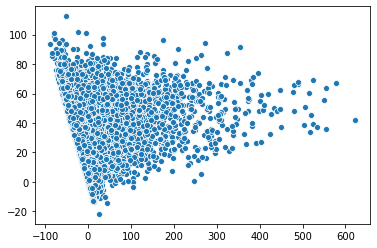

In [36]:
sns.scatterplot(full_ols.resid, full_ols.fittedvalues);

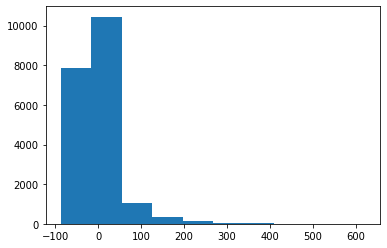

In [37]:
plt.hist(full_ols.resid);

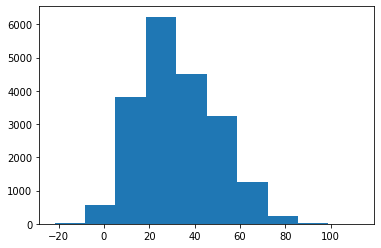

In [38]:
plt.hist(full_ols.fittedvalues);